# Homotopic optimal control of inverted pendulum

## Dynamics

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state variables
x, v, theta, omega = symbols("x v \\theta, \\omega", real=True)
s = Matrix([x, v, theta, omega])
s.T

In [ ]:
# control parameter
u = symbols('u', real=True, nonzero=True)

# state equations of motion
ds = Matrix([v, u, omega, sin(theta) - u*cos(theta)])
ds

In [ ]:
# homotopy parameters
alpha, beta = symbols('\\alpha \\beta', real=True, nonegative=True)

# homotopy between effort and time
L = beta + (1-beta)*abs(u)

# homotopy between energy and effort/time
L = alpha*L + (1-alpha)*u**2
L

In [ ]:
# costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True, nonzero=True)
l.T

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
# optimal control; note that alpha dissappears
# because effort and time optimality are equivalent in this case
us = solve(H.diff(u), u)[0]
us

In [ ]:
# effort/time optimal control (bang-bang)
us.subs(alpha, 1)

## Base trajectory
We first solve for a base trajectory, which will subsequently be used to iniate the forthcoming homotopy sequence approach to reaching the difficultly found bang-bang optimal control.

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append('../src/')
from pendulum import Pendulum
%matplotlib inline

In [2]:
# instantiate problem
seg = Pendulum()

# solve arguments
s0 = [0,0,np.pi,0]
alpha = 0
Tlb = 5
Tub = 15
lb = 1

In [3]:
# solve
zg = None
zg = [10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696]
#zg = [6.12032571, 0.03676911, 0.90012948, 1.40507211, 0.39248787]
while True:
    z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)
    if feas:
        break
z

array([10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696])

In [4]:
# simulate the solution's resultant trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)

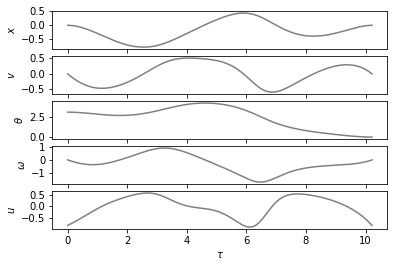

In [5]:
# plot states and control
fig, ax = seg.plot_states(tl, sl, ul)

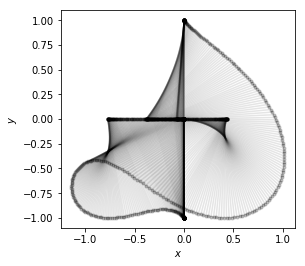

In [6]:
# plot geometric trajectory
fig, ax = seg.plot_traj(tl, sl)

## Policy homotopy

```python
zo = None
a = 0
while a < 1:
    z = solve(zo, a)
    if succesfull(z):
        zo = z
        a = increase(a)
    else:
        a = decrease(a)
```

## Forward homotopy $\alpha: 0 \rightarrow 1$
This brings us to a bang-bang policy with an appropriate magnitude, which is realisable from the original quadratic policy.

In [7]:
#sols = seg.homotopy(s0, 0, Tlb, Tub, 10, z, 1, step=0.001)
sols = np.load("ph.npy")

In [8]:
#np.save('ph.npy', np.flip(sols, axis=0))

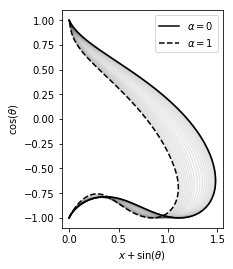

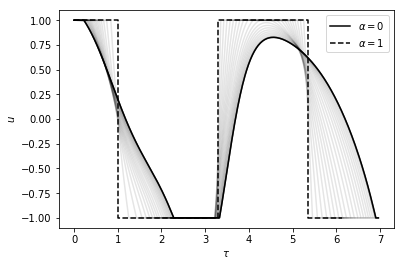

In [9]:
# plot the forward homotopy 
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
for i in range(len(sols)):
    z = sols[i][0]
    a = sols[i][1]
    seg.alpha = a
    tl, sl, ul = seg.propagate(z[0], s0, z[1:], a, u=True)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    if a == 0:
        ax.plot(x, y, "k-", alpha=1, label=r"$\alpha=0$")
        ax1.plot(tl, ul, "k-", alpha=1, label=r"$\alpha=0$")
    elif a == 1:
        ax.plot(x, y, "k--", alpha=1, label=r"$\alpha=1$")
        ax1.plot(tl, ul, "k--", alpha=1, label=r"$\alpha=1$")
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
ax.legend()
ax1.legend()
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
fig.savefig("phs.pdf", bbox_inches='tight')
fig1.savefig("phu.pdf", bbox_inches='tight')

## Random walks

```python
T = []
so = snom
zo = znom
while len(T) < N:
    s = perturb(so, ds)
    z = solve(s, zo)
    if succesfull(z):
        so = s
        zo = z
        T.append((so, zo))
        ds = increase(ds)
    else:
        ds = decrease(ds)
        
```

In [ ]:
sols[0]

In [10]:
# arguments
so = s0
zo = zg
zo = sols[0][0]
alpha = 0
n = 1
Tlb = 0
Tub = 15
lb = 5
nw = 8

# random walks
T = seg.random_walk_par(so, zo, alpha, n, Tlb, Tub, lb, nw, dsm=0.02, verbose=True)
#T = np.load('pqdb.npy')

Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02


In [ ]:
#np.save('pqdb.npy', T)

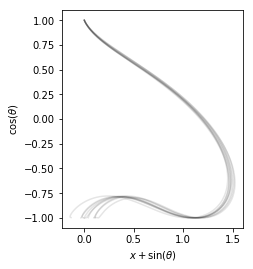

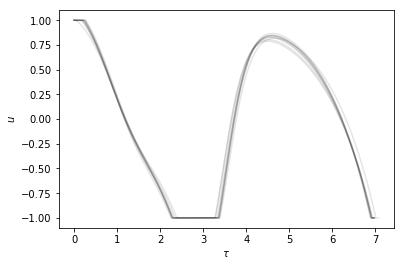

In [11]:
# plot the random walks
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

# for each random walk
first = False
for t in T:
    
    # initial state
    s0 = t[0]
    
    # decision vector
    z = t[1]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if first:
        ax.plot(x, y, "k-", alpha=1, label="Nominal")
        ax1.plot(tl, ul, "k-", alpha=1, label="Nominal")
        first = False
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
#ax.legend()
#ax1.legend()
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
#fig.savefig('pqdbs.pdf', bbox_inches='tight')
#fig1.savefig('pqdbu.pdf', bbox_inches='tight')

## Database homotopy

In [12]:
res = seg.homotopy_db(T, 0, 0, 15, 5, 1, step=0.01)
#res = np.load('pqhdb.npy')

z=[ 6.95087686  0.28681837  0.17282741 -1.06199158 -2.44818139]
a=0.0
z=[ 6.96362291  0.34577269  0.33113881 -1.11776598 -2.60515498]
a=0.0
z=[ 6.96037805  0.30109599  0.20825235 -1.07882774 -2.4866364 ]
a=0.0
z=[ 6.97231416  0.38313855  0.4621362  -1.17247963 -2.68527247]
a=0.0
z=[ 6.96209278  0.33095384  0.2943599  -1.11307475 -2.53239128]
a=0.0
z=[ 6.98219016  0.34496908  0.3145202  -1.13898251 -2.50132824]
a=0.0
z=[ 6.97803304  0.35465916  0.35955107 -1.15030111 -2.54861862]
a=0.0
z=[ 6.97067964  0.32815059  0.28045422 -1.06478973 -2.57667789]
a=0.0
z=[ 6.94638626  0.28392165  0.16691444 -1.06002387 -2.42464311]
a=0.01
z=[ 6.95885594  0.34230301  0.32304744 -1.11662597 -2.58104346]
a=0.01
z=[ 6.95576457  0.29806765  0.20185596 -1.07705784 -2.4629206 ]
a=0.01
z=[ 6.97771703  0.34149898  0.30683977 -1.1370414  -2.47772898]
a=0.01
z=[ 6.96720809  0.37938425  0.45270124 -1.17169264 -2.66087696]
a=0.01
z=[ 6.95744856  0.32763587  0.28691207 -1.11142639 -2.50852524]
a=0.01
z=[ 6.97337318

a=0.13999999999999999
z=[ 6.91865054  0.31197956  0.26268798 -1.1256433  -2.26125411]
a=0.11999999999999998
z=[ 6.89792666  0.28746174  0.19854683 -1.08701956 -2.22121355]
a=0.12999999999999998
z=[ 6.90111898  0.33388261  0.3396582  -1.1583519  -2.3674239 ]
a=0.12999999999999998
z=[ 6.9062478   0.28471568  0.18416468 -1.04707855 -2.26393749]
a=0.12999999999999998
z=[ 6.87847652  0.24294678  0.08553    -1.02684058 -2.09403862]
a=0.15z=[ 6.91520142  0.29597519  0.20809291 -1.10627112 -2.16992523]
a=0.13999999999999999

z=[ 6.89757188  0.30027502  0.22673975 -1.09855457 -2.29070641]
a=0.12999999999999998
z=[ 6.88594255  0.25521648  0.11363305 -1.04655401 -2.12973997]
a=0.15
z=[ 6.89260464  0.28408204  0.19126238 -1.08460412 -2.19719288]
a=0.13999999999999999
z=[ 6.91337233  0.30839001  0.25471458 -1.12313363 -2.23722354]
a=0.12999999999999998
z=[ 6.89515543  0.33005007  0.33024432 -1.15692552 -2.3429117 ]
a=0.13999999999999999
z=[ 6.87320292  0.23998754  0.07980926 -1.02407353 -2.07034566

a=0.26000000000000006
z=[ 6.8177395   0.28349417  0.21811956 -1.13421231 -2.04765907]
a=0.26000000000000006
z=[ 6.80511149  0.20410941  0.01283689 -0.9851584  -1.78500883]
a=0.2800000000000001
z=[ 6.84914374  0.25320168  0.1195089  -1.06707305 -1.88377112]
a=0.26000000000000006
z=[ 6.83831573  0.24385443  0.0978533  -1.02048008 -1.97283391]
a=0.25000000000000006
z=[ 6.82400549  0.24310774  0.10544929 -1.04960502 -1.90775543]
a=0.26000000000000006
z=[ 6.84489193  0.26487158  0.16010151 -1.08769982 -1.94783158]
a=0.25000000000000006
z=[ 6.81695594  0.21773709  0.04069531 -1.01015948 -1.84213817]
a=0.2700000000000001
z=[ 6.82729355  0.25743071  0.13224129 -1.07136922 -1.99826807]
a=0.25000000000000006
z=[ 6.83225974  0.24041398  0.0908416  -1.01767436 -1.94844191]
a=0.26000000000000006
z=[ 6.81070699  0.2795632   0.20882417 -1.13189069 -2.02297274]
a=0.2700000000000001
z=[ 6.84321425  0.24960158  0.11227739 -1.06325443 -1.85982066]
a=0.2700000000000001
z=[ 6.81788581  0.23965755  0.098480

a=0.36000000000000015
z=[ 6.77248692  0.22418261  0.07601859 -1.04454889 -1.6805179 ]
a=0.36000000000000015
z=[ 6.77916796  0.21325613  0.04115318 -1.02044946 -1.61941459]
a=0.37000000000000016
z=[ 6.75215495  0.2048196   0.03028933 -1.0058319  -1.64018792]
a=0.37000000000000016
z=[ 6.74550374  0.21362228  0.04061121 -1.0324937  -1.70318832]
a=0.37000000000000016
z=[ 6.76533351  0.22044109  0.06852063 -1.04006782 -1.65611062]
a=0.37000000000000016
z=[ 6.70582544  0.22750629  0.08604505 -1.10045114 -1.70213887]
a=0.4000000000000002
z=[ 6.75962132  0.20213805  0.01489522 -0.98191891 -1.67895164]
a=0.37000000000000016
z=[ 6.71939333  0.16442266 -0.05493901 -0.92834212 -1.47342985]
a=0.4100000000000002
z=[ 6.74447427  0.18269798 -0.02268969 -0.9655934  -1.57644865]
a=0.38000000000000017
z=[ 6.77227739  0.20958681  0.03421588 -1.01559712 -1.59526736]
a=0.38000000000000017
z=[ 6.74511235  0.20130191  0.02366871 -1.00120208 -1.61574219]
a=0.38000000000000017
z=[ 6.73804676  0.20992243  0.0331

a=0.48000000000000026
z=[ 6.66897255  0.15024762 -0.07585365 -0.91258128 -1.33282529]
a=0.48000000000000026
z=[ 6.63904381  0.1682079  -0.05544292 -0.9938891  -1.40784174]
a=0.49000000000000027
z=[ 6.66348282  0.15927986 -0.06559844 -0.93220687 -1.38238031]
a=0.49000000000000027
z=[ 6.63391145  0.13013883 -0.10639625 -0.86429234 -1.20736409]
a=0.5200000000000002
z=[ 6.66075102  0.17447353 -0.0271457  -0.99222957 -1.36391583]
a=0.49000000000000027
z=[ 6.60387477  0.18299695 -0.02475055 -1.07722457 -1.43481119]
a=0.5100000000000002
z=[ 6.65966418  0.16212671 -0.04704165 -0.94335044 -1.34553725]
a=0.49000000000000027
z=[ 6.66079956  0.14697042 -0.08087972 -0.90651388 -1.30834204]
a=0.49000000000000027
z=[ 6.68148462  0.16834987 -0.0463065  -0.96601118 -1.32975652]
a=0.49000000000000027
z=[ 6.65289651  0.15555593 -0.07352285 -0.92979846 -1.35791604]
a=0.5000000000000002
z=[ 6.62540856  0.12699092 -0.11070702 -0.85755483 -1.18305013]
a=0.5300000000000002
z=[ 6.64978339  0.15845319 -0.054314

a=0.5900000000000003
z=[ 6.53592943  0.11497075 -0.15977859 -0.89647275 -1.09022199]
a=0.6100000000000003
z=[ 6.49871766  0.09064086 -0.16992097 -0.79902648 -0.91603615]
a=0.6400000000000003
z=[ 6.48716643  0.13452305 -0.15096288 -1.04961301 -1.14873359]
a=0.6300000000000003
z=[ 6.5309786   0.10600207 -0.15220031 -0.84789546 -1.01542415]
a=0.6100000000000003
z=[ 6.53956757  0.1280766  -0.13045811 -0.94690477 -1.07546825]
a=0.6100000000000003
z=[ 6.52755431  0.11753044 -0.1411415  -0.90081148 -1.05483603]
a=0.6100000000000003
z=[ 6.50956503  0.11884399 -0.16622037 -0.95177544 -1.0926024 ]
a=0.6200000000000003
z=[ 6.52520234  0.11131448 -0.16756248 -0.89286104 -1.06602895]
a=0.6200000000000003
z=[ 6.56971948  0.12626307 -0.13701093 -0.92501094 -1.06723483]
a=0.6000000000000003
z=[ 6.48486637  0.08723962 -0.17641864 -0.79505561 -0.89201926]
a=0.6500000000000004
z=[ 6.47710196  0.13047974 -0.16187946 -1.04743022 -1.12529835]
a=0.6400000000000003
z=[ 6.51836294  0.10252479 -0.15898078 -0.84

a=0.7500000000000004
z=[ 6.39214482  0.06822626 -0.22395565 -0.79460087 -0.75150112]
a=0.7200000000000004
z=[ 6.40845074  0.08150906 -0.238722   -0.89621596 -0.79124466]
a=0.7300000000000004
z=[ 6.37944162  0.07306739 -0.27587355 -0.91160991 -0.80778175]
a=0.7400000000000004
z=[ 6.44077614  0.08042255 -0.23724571 -0.86957855 -0.78316154]
a=0.7200000000000004
z=[ 6.38911159  0.07334918 -0.23593384 -0.84662709 -0.76826244]
a=0.7300000000000004
z=[ 6.38919694  0.06728531 -0.26484392 -0.84853362 -0.77882701]
a=0.7400000000000004
z=[ 6.33453697  0.0506619  -0.24244282 -0.73645049 -0.63011348]
a=0.7600000000000005
z=[ 6.37892574  0.06480047 -0.23058835 -0.78936478 -0.7277488 ]
a=0.7300000000000004
z=[ 6.35555272  0.08209828 -0.29951599 -1.02555009 -0.85214547]
a=0.7600000000000005
z=[ 6.39701428  0.07760039 -0.24826629 -0.89210948 -0.76788294]
a=0.7400000000000004
z=[ 6.36825276  0.0692308  -0.28558911 -0.90849922 -0.78448135]
a=0.7500000000000004
z=[ 6.37690127  0.06964632 -0.24427173 -0.84

a=0.8400000000000005
z=[ 6.22620799  0.02679931 -0.31027506 -0.7346112  -0.47101592]
a=0.8400000000000005
z=[ 6.2568863   0.03945951 -0.4356383  -1.0164618  -0.62547801]
a=0.8700000000000006
z=[ 6.26139752  0.03031977 -0.37282355 -0.84788781 -0.49403221]
a=0.8600000000000005
z=[ 6.24712668  0.02260882 -0.37720498 -0.81103722 -0.50186122]
a=0.8600000000000005
z=[ 6.15615803  0.01034335 -0.32510462 -0.67268995 -0.35256518]
a=0.8800000000000006
z=[ 6.24912475  0.02691035 -0.40089259 -0.87956252 -0.53544116]
a=0.8600000000000005
z=[ 6.24065788  0.02855164 -0.34423598 -0.79736234 -0.49066103]
a=0.8500000000000005
z=[ 6.21215571  0.02330223 -0.31844707 -0.73025429 -0.44823626]
a=0.8500000000000005
z=[ 6.24952994  0.03586622 -0.44796387 -1.01632362 -0.6071061 ]
a=0.8800000000000006
z=[ 6.29070954  0.02962769 -0.36037415 -0.81095444 -0.48101399]
a=0.8500000000000005
z=[ 6.25100452  0.02636565 -0.38419609 -0.84481345 -0.47197236]
a=0.8700000000000006
z=[ 6.23608086  0.01885628 -0.38765638 -0.80

a=0.9500000000000006
z=[ 6.15266068 -0.01661314 -0.49510596 -0.79072892 -0.27547016]
a=0.9700000000000006
z=[ 6.17184131 -0.0087469  -0.51302317 -0.86468947 -0.33837502]
a=0.9600000000000006
z=[ 6.20218149  0.00894906 -0.54559663 -1.01903505 -0.47353472]
a=0.9900000000000003
z=[ 6.08286527 -0.01517388 -0.42265589 -0.69484215 -0.20960278]
a=0.9600000000000006
z=[ 6.13347415 -0.01186707 -0.46219727 -0.76746199 -0.25778724]
a=0.9600000000000006
z=[ 6.14882026 -0.01909677 -0.50332234 -0.78978334 -0.26164583]
a=0.9800000000000006
z=[ 6.17009209 -0.01234202 -0.50545414 -0.82036287 -0.26338172]
a=0.9800000000000006
z=[ 6.16778229 -0.01133382 -0.52183313 -0.86397339 -0.32455779]
a=0.9700000000000006
z=[ 6.18920107 -0.0143716  -0.48604358 -0.76971515 -0.23507991]
a=0.9600000000000006
z=[ 6.0759844  -0.01834086 -0.43242925 -0.69269786 -0.19080042]
a=0.9700000000000006
z=[ 6.16794012 -0.01390967 -0.51081076 -0.8195715  -0.25522219]
a=0.9900000000000003
z=[ 6.14635037 -0.02085419 -0.50919209 -0.78

a=0.6700000000000004
z=[ 6.56097343  0.10478793 -0.110267   -0.77379131 -0.84748295]
a=0.6800000000000004
z=[ 6.54855575  0.10090176 -0.11872614 -0.76892971 -0.82382863]
a=0.6900000000000004
z=[ 6.53599548  0.09701144 -0.12723458 -0.76402933 -0.80019837]
a=0.7000000000000004
z=[ 6.52334598  0.09311947 -0.13573901 -0.75900091 -0.77657947]
a=0.7100000000000004
z=[ 6.51057197  0.08922372 -0.14427589 -0.75389973 -0.75298068]
a=0.7200000000000004
z=[ 6.4976827   0.08532436 -0.1528382  -0.74871073 -0.72940043]
a=0.7300000000000004
z=[ 6.48462972  0.08141813 -0.16148476 -0.74352238 -0.70585308]
a=0.7400000000000004
z=[ 6.47146384  0.07750735 -0.17016739 -0.73825354 -0.68232712]
a=0.7500000000000004
z=[ 6.45814756  0.07358899 -0.1789403  -0.73298364 -0.65883584]
a=0.7600000000000005
z=[ 6.44472615  0.069665   -0.18776352 -0.72764442 -0.63536956]
a=0.7700000000000005
z=[ 6.43118742  0.06573352 -0.19666871 -0.72227872 -0.61193597]
a=0.7800000000000005
z=[ 6.41753321  0.06179329 -0.20567665 -0.71

In [ ]:
#np.save('pqhdb.npy', res)

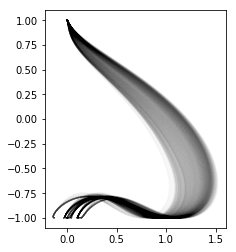

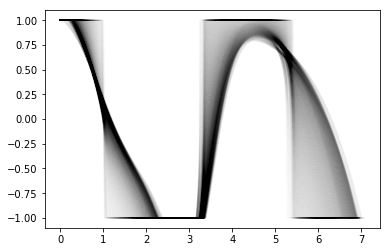

In [13]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

for r in res:
    
    # initial state
    s0 = r[0]
    
    # decision vector
    z = r[1]
    
    # homotopy parameter
    alpha = r[2]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if alpha > 1.2:
        ax.plot(x, y, "k--", alpha=1)
        ax1.plot(tl, ul, "k--", alpha=1)
    else:
        ax.plot(x, y, "k-", alpha=0.01)
        ax1.plot(tl, ul, "k-", alpha=0.01)
ax.set_aspect('equal')
    
plt.show()    
#fig1.savefig('phdbu.pdf')

# Training a neural network

In [15]:
from ann import *

In [16]:
# generate the databases
data = seg.gen_db(res, cat=True)
#data = np.load('pqhanndb.npy')

In [ ]:
# save the database
#np.save('pqhanndb.npy', data)

In [17]:
# format the data for the ann
db = Data(data, [0, 1, 2, 3, 4], [5])

In [18]:
# instantiate the neural network
mlp = Pendulum_Controller([5, 40, 40, 40, 1])

In [ ]:
mlp.train(db.i, db.o, epo=1000, lr=1e-4, gpu=True)

Episode 0; Testing Loss 0.0057494137234065; Training Loss 0.005722291424917129
Episode 1; Testing Loss 0.006656758299195697; Training Loss 0.006590595948402279
Episode 2; Testing Loss 0.0058016176973202; Training Loss 0.005766789005545725
Episode 3; Testing Loss 0.005945723611425868; Training Loss 0.005931471827753168
Episode 4; Testing Loss 0.00623949721841565; Training Loss 0.006230246054643107
Episode 5; Testing Loss 0.0060892642394508; Training Loss 0.0060773441694265415
Episode 6; Testing Loss 0.005822547117391243; Training Loss 0.005803352023352372
Episode 7; Testing Loss 0.005750715039963482; Training Loss 0.005720808963919184
Episode 8; Testing Loss 0.005889421681706323; Training Loss 0.0058489826489678005
Episode 9; Testing Loss 0.006013501202184671; Training Loss 0.005967501014818324
Episode 10; Testing Loss 0.005976292119316691; Training Loss 0.005931720602237645
Episode 11; Testing Loss 0.005841609835438484; Training Loss 0.005803548702335167
Episode 12; Testing Loss 0.0057

Episode 102; Testing Loss 0.005647473378647162; Training Loss 0.005618010405669027
Episode 103; Testing Loss 0.00564641502845333; Training Loss 0.00561680838445242
Episode 104; Testing Loss 0.005645361670908005; Training Loss 0.005615622966956662
Episode 105; Testing Loss 0.0056442358241345515; Training Loss 0.0056144340089351675
Episode 106; Testing Loss 0.005643004995674565; Training Loss 0.0056132265113418185
Episode 107; Testing Loss 0.0056417238598107005; Training Loss 0.0056120213676120675
Episode 108; Testing Loss 0.005640475616586196; Training Loss 0.005610815143979075
Episode 109; Testing Loss 0.005639294020455276; Training Loss 0.0056095923583159395
Episode 110; Testing Loss 0.005638178812722245; Training Loss 0.00560835261190531
Episode 111; Testing Loss 0.005637091517590219; Training Loss 0.005607110847278782
Episode 112; Testing Loss 0.005635988076474172; Training Loss 0.005605867141451131
Episode 113; Testing Loss 0.005634838516367857; Training Loss 0.005604637704537146
E

Episode 202; Testing Loss 0.005521943277977058; Training Loss 0.005490489031053852
Episode 203; Testing Loss 0.005520615300509719; Training Loss 0.005489155519163483
Episode 204; Testing Loss 0.005519292753932268; Training Loss 0.005487822822332473
Episode 205; Testing Loss 0.005517975224642164; Training Loss 0.005486489096851132
Episode 206; Testing Loss 0.0055166445192472375; Training Loss 0.005485153052094067
Episode 207; Testing Loss 0.005515300733492365; Training Loss 0.005483816064440701
Episode 208; Testing Loss 0.00551395920844424; Training Loss 0.005482481193519087
Episode 209; Testing Loss 0.0055126394998259495; Training Loss 0.0054811420841850405
Episode 210; Testing Loss 0.005511317353871145; Training Loss 0.005479805135556513
Episode 211; Testing Loss 0.005509987820728875; Training Loss 0.0054784662157189275
Episode 212; Testing Loss 0.005508643703084013; Training Loss 0.005477125890592704
Episode 213; Testing Loss 0.005507296960362132; Training Loss 0.005475787809498616
E

Episode 302; Testing Loss 0.005386604237579509; Training Loss 0.005354577406063619
Episode 303; Testing Loss 0.005385237905013071; Training Loss 0.005353196029143894
Episode 304; Testing Loss 0.005383881960041293; Training Loss 0.005351814085185303
Episode 305; Testing Loss 0.005382510541358033; Training Loss 0.00535042806927552
Episode 306; Testing Loss 0.005381134939609422; Training Loss 0.005349046363671428
Episode 307; Testing Loss 0.005379759091875547; Training Loss 0.005347661353006612
Episode 308; Testing Loss 0.005378386524214854; Training Loss 0.005346276304244951
Episode 309; Testing Loss 0.0053770138489951215; Training Loss 0.005344893967018378
Episode 310; Testing Loss 0.005375642305418428; Training Loss 0.0053435062780060215
Episode 311; Testing Loss 0.005374289602594875; Training Loss 0.005342123919134409
Episode 312; Testing Loss 0.005372918546019636; Training Loss 0.0053407386087242666
Episode 313; Testing Loss 0.005371525871568048; Training Loss 0.005339346638726485
Ep

Episode 402; Testing Loss 0.005241691219511077; Training Loss 0.005212028400556215
Episode 403; Testing Loss 0.005240293713375672; Training Loss 0.005210601859580147
Episode 404; Testing Loss 0.005238888201668004; Training Loss 0.005209183461964516
Episode 405; Testing Loss 0.005237456385822077; Training Loss 0.00520776220182148
Episode 406; Testing Loss 0.005236024583569121; Training Loss 0.005206336845856804
Episode 407; Testing Loss 0.005234597744868079; Training Loss 0.005204908589686758
Episode 408; Testing Loss 0.005233169034998301; Training Loss 0.00520348203377488
Episode 409; Testing Loss 0.005231754660422184; Training Loss 0.005202062207382624
Episode 410; Testing Loss 0.0052303286778107305; Training Loss 0.005200638483147833
Episode 411; Testing Loss 0.005228897103461249; Training Loss 0.005199217981538729
Episode 412; Testing Loss 0.005227473771044511; Training Loss 0.005197794590966589
Episode 413; Testing Loss 0.005226060323831816; Training Loss 0.005196373156732591
Episo

Episode 502; Testing Loss 0.005099779834036175; Training Loss 0.005069189947939684
Episode 503; Testing Loss 0.00509837175627919; Training Loss 0.005067768577360545
Episode 504; Testing Loss 0.005096915495559199; Training Loss 0.005066342733433395
Episode 505; Testing Loss 0.005095488569602518; Training Loss 0.005064916599035452
Episode 506; Testing Loss 0.0050940920343722565; Training Loss 0.005063488338975743
Episode 507; Testing Loss 0.00509268966470422; Training Loss 0.005062059714996502
Episode 508; Testing Loss 0.005091256490171232; Training Loss 0.005060639465696895
Episode 509; Testing Loss 0.005089827252135596; Training Loss 0.005059209124623556
Episode 510; Testing Loss 0.005088465512070778; Training Loss 0.005057787475411907
Episode 511; Testing Loss 0.005087104219434008; Training Loss 0.0050563661081147755
Episode 512; Testing Loss 0.005085703147348911; Training Loss 0.0050549426812997855
Episode 513; Testing Loss 0.005084273307955923; Training Loss 0.005053519682271847
Epi

Episode 602; Testing Loss 0.004959951989430647; Training Loss 0.004927160720229306
Episode 603; Testing Loss 0.00495854175172349; Training Loss 0.00492574700327885
Episode 604; Testing Loss 0.004957139812898712; Training Loss 0.004924333334741006
Episode 605; Testing Loss 0.004955737586769753; Training Loss 0.004922920520564794
Episode 606; Testing Loss 0.00495432453471497; Training Loss 0.004921506830175605
Episode 607; Testing Loss 0.0049529050065730915; Training Loss 0.004920092859893608
Episode 608; Testing Loss 0.004951483313153093; Training Loss 0.004918679139528055
Episode 609; Testing Loss 0.004950057384297449; Training Loss 0.004917263858060681
Episode 610; Testing Loss 0.004948632205911824; Training Loss 0.004915849363527355
Episode 611; Testing Loss 0.004947210212878151; Training Loss 0.004914433403302236
Episode 612; Testing Loss 0.004945808566853331; Training Loss 0.004913017065341615
Episode 613; Testing Loss 0.004944428901803136; Training Loss 0.004911603358593746
Episod

Episode 702; Testing Loss 0.004820406390323661; Training Loss 0.00478714913201703
Episode 703; Testing Loss 0.004819027006604175; Training Loss 0.004785765022148295
Episode 704; Testing Loss 0.004817643287769586; Training Loss 0.0047843807557966
Episode 705; Testing Loss 0.004816239286821741; Training Loss 0.004782997324225574
Episode 706; Testing Loss 0.004814821257327356; Training Loss 0.004781613172199939
Episode 707; Testing Loss 0.00481342075234719; Training Loss 0.004780230766699505
Episode 708; Testing Loss 0.004812028092143481; Training Loss 0.004778848569337609
Episode 709; Testing Loss 0.004810622930395893; Training Loss 0.004777466834651159
Episode 710; Testing Loss 0.0048092220675540805; Training Loss 0.004776085703707611
Episode 711; Testing Loss 0.004807833842965572; Training Loss 0.0047747054315992144
Episode 712; Testing Loss 0.0048064353957366695; Training Loss 0.004773322981204188
Episode 713; Testing Loss 0.004805037547930354; Training Loss 0.0047719421243747956
Epis

Episode 802; Testing Loss 0.00468406254874781; Training Loss 0.004649645952960494
Episode 803; Testing Loss 0.004682695307416408; Training Loss 0.0046482812925341755
Episode 804; Testing Loss 0.004681340259834644; Training Loss 0.004646919297562728
Episode 805; Testing Loss 0.004679932398429029; Training Loss 0.00464555578320408
Episode 806; Testing Loss 0.004678569354356856; Training Loss 0.004644191212525295
Episode 807; Testing Loss 0.004677188486102979; Training Loss 0.004642829351281221
Episode 808; Testing Loss 0.004675766697392428; Training Loss 0.004641467256166138
Episode 809; Testing Loss 0.004674411300454039; Training Loss 0.004640105220939175
Episode 810; Testing Loss 0.004673076767898979; Training Loss 0.00463874433435974
Episode 811; Testing Loss 0.004671680905087858; Training Loss 0.004637383542312259
Episode 812; Testing Loss 0.004670296245331118; Training Loss 0.0046360207445649785
Episode 813; Testing Loss 0.0046689293474317176; Training Loss 0.004634658342328515
Epis

Episode 902; Testing Loss 0.004546817391025661; Training Loss 0.004512902521311447
Episode 903; Testing Loss 0.004545344250330345; Training Loss 0.004511537547767134
Episode 904; Testing Loss 0.004543994271041136; Training Loss 0.004510169133843388
Episode 905; Testing Loss 0.004542690830112583; Training Loss 0.004508804700703344
Episode 906; Testing Loss 0.004541322872028855; Training Loss 0.004507446407221733
Episode 907; Testing Loss 0.004539950621045465; Training Loss 0.004506081615976025
Episode 908; Testing Loss 0.0045386004005121125; Training Loss 0.004504720239763925
Episode 909; Testing Loss 0.004537186786312342; Training Loss 0.00450336209715641
Episode 910; Testing Loss 0.004535844867000424; Training Loss 0.004502000610731046
Episode 911; Testing Loss 0.004534539780363709; Training Loss 0.00450064192037175
Episode 912; Testing Loss 0.004533141146452771; Training Loss 0.004499279078428499
Episode 913; Testing Loss 0.004531751721144445; Training Loss 0.004497918239888369
Episo

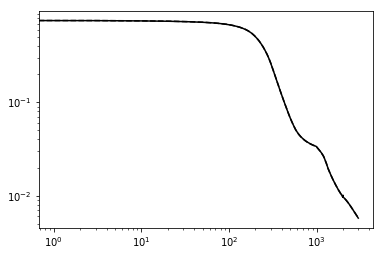

In [25]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

## Simulating the neural network controller

In [ ]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
s0 = np.array([0, 0, np.pi, 0])
n = 10
for alpha, alphac in zip(np.linspace(0, 1, n), np.linspace(0.2, 0.8, n)):
    T = 6.5
    tl, sl, ul = seg.propagate_controller(T, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    ax.plot(x, y, "k-", alpha=alphac)
    ax1.plot(tl, ul, "k-", alpha=alphac)
ax.set_aspect('equal')
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()

## Neural network accuracy

In [ ]:
n = 2

fig, ax = plt.subplots(n, sharex=True)
s = np.array([0, 0, np.pi, 0])
il = np.linspace(0, len(sols)-1, n, dtype=int)
for i, j in zip(il, range(n)):
    
    # simulate
    z = sols[i][0]
    alpha = sols[i][1]
    tl, sl, ul = seg.propagate(z[0], s, z[1:], alpha, u=True)
    tst = torch.tensor(np.hstack((sl[:, :seg.sdim], np.full((len(sl), 1), alpha))))
    tst = mlp(tst).detach().numpy().flatten()
    ax[j].plot(tl, ul, "k--")
    ax[j].plot(tl, tst, "k-", alpha=0.5)
    ax[j].set_title(r'$\alpha = {:.0f}$'.format(alpha))
    ax[j].set_ylabel(r'$u$')
    
ax[-1].set_xlabel(r'$\tau$')
ax[-1].legend(['Ground truth', 'Prediction'])
    
plt.tight_layout()
plt.show()
fig.savefig('punn.pdf', bbox_inches='tight')

In [ ]:
import pykep as pk


In [ ]:
pk.epoch(0).mjd2000

In [ ]:
np.array(pk.planet.jpl_lp('mars').osculating_elements(pk.epoch(0)))[:5]